In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
df = pd.read_csv(r"C:\Users\Amanda\Downloads\datasets_4471_6849_bank.csv",sep=',')

df.head(5)
term_deposits = df.copy()
# Have a grasp of how our data looks.
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [3]:
dep = term_deposits['deposit']
term_deposits.drop(labels=['deposit'], axis=1,inplace=True)
term_deposits.insert(0, 'deposit', dep)
term_deposits.head()
# housing has a -20% correlation with deposit let's see how it is distributed.
# 52 %
term_deposits["housing"].value_counts()/len(term_deposits)

no     0.526877
yes    0.473123
Name: housing, dtype: float64

In [4]:
term_deposits["loan"].value_counts()/len(term_deposits)

no     0.869199
yes    0.130801
Name: loan, dtype: float64

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
# Here we split the data into training and test sets and implement a stratified shuffle split.
stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_set, test_set in stratified.split(term_deposits, term_deposits["loan"]):
    stratified_train = term_deposits.loc[train_set]
    stratified_test = term_deposits.loc[test_set]
    
stratified_train["loan"].value_counts()/len(df)
stratified_test["loan"].value_counts()/len(df)

no     0.260796
yes    0.039240
Name: loan, dtype: float64

In [6]:
train_data = stratified_train
test_data = stratified_test
train_data.shape
test_data.shape
train_data['deposit'].value_counts()

no     4082
yes    3731
Name: deposit, dtype: int64

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7813 entries, 7168 to 9672
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deposit    7813 non-null   object
 1   age        7813 non-null   int64 
 2   job        7813 non-null   object
 3   marital    7813 non-null   object
 4   education  7813 non-null   object
 5   default    7813 non-null   object
 6   balance    7813 non-null   int64 
 7   housing    7813 non-null   object
 8   loan       7813 non-null   object
 9   contact    7813 non-null   object
 10  day        7813 non-null   int64 
 11  month      7813 non-null   object
 12  duration   7813 non-null   int64 
 13  campaign   7813 non-null   int64 
 14  pdays      7813 non-null   int64 
 15  previous   7813 non-null   int64 
 16  poutcome   7813 non-null   object
dtypes: int64(7), object(10)
memory usage: 1.1+ MB


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Making pipelines
numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["age", "balance", "day", "campaign", "pdays", "previous","duration"])),
    ("std_scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["job", "education", "marital", "default", "housing", "loan", "contact", "month",
                                     "poutcome"])),
    ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))
])

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
    ])

In [13]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.18725577, -0.49025624, -0.91132125, ...,  0.        ,
         0.        ,  1.        ],
       [-1.10829525, -0.17907924,  1.10079039, ...,  0.        ,
         0.        ,  1.        ],
       [-0.7733718 , -0.33320453,  0.27227383, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.81751457, -1.12236502, -1.02968076, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.39886026, -0.21679766, -1.14804027, ...,  0.        ,
         0.        ,  1.        ],
       [-0.60591008, -0.34621088,  1.69258793, ...,  1.        ,
         0.        ,  0.        ]])

In [14]:
y_train = train_data['deposit']
y_test = test_data['deposit']
y_train.shape

(7813,)

In [15]:
from sklearn.preprocessing import LabelEncoder

encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)
y_train_yes = (y_train == 1)
y_train
y_train_yes

array([False,  True, False, ...,  True, False, False])

In [16]:
some_instance = X_train[1250]

In [17]:
import time


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=18),
    "Neural Net": MLPClassifier(alpha=1),
    "Naive Bayes": GaussianNB()
}

In [18]:
no_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, Y_train, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['classifier', 'train_score', 'training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'training_time'] = t_diff
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
    return df_results

In [19]:
df_results = batch_classify(X_train, y_train)
print(df_results.sort_values(by='train_score', ascending=False))

C:\Users\Amanda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


trained Logistic Regression in 0.65 s
trained Nearest Neighbors in 0.19 s
trained Linear SVM in 2.67 s
trained Gradient Boosting Classifier in 1.72 s
trained Decision Tree in 0.07 s
trained Random Forest in 0.17 s
trained Neural Net in 4.65 s
trained Naive Bayes in 0.01 s
                     classifier  train_score  training_time
4                 Decision Tree     1.000000       0.069614
5                 Random Forest     0.998336       0.171055
2                    Linear SVM     0.881608       2.666053
3  Gradient Boosting Classifier     0.862665       1.715020
1             Nearest Neighbors     0.862025       0.189876
6                    Neural Net     0.844618       4.645063
0           Logistic Regression     0.832459       0.652285
7                   Naive Bayes     0.723154       0.010564


In [20]:
# Use Cross-validation.
from sklearn.model_selection import cross_val_score

# Logistic Regression
log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, X_train, y_train, cv=10)
log_reg_mean = log_scores.mean()

# SVC
svc_clf = SVC()
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=10)
svc_mean = svc_scores.mean()

# KNearestNeighbors
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=10)
knn_mean = knn_scores.mean()

# Decision Tree
tree_clf = tree.DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=10)
tree_mean = tree_scores.mean()

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=10)
grad_mean = grad_scores.mean()

# Random Forest Classifier
rand_clf = RandomForestClassifier(n_estimators=18)
rand_scores = cross_val_score(rand_clf, X_train, y_train, cv=10)
rand_mean = rand_scores.mean()

# NeuralNet Classifier
neural_clf = MLPClassifier(alpha=1)
neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=10)
neural_mean = neural_scores.mean()

# Naives Bayes
nav_clf = GaussianNB()
nav_scores = cross_val_score(nav_clf, X_train, y_train, cv=10)
nav_mean = neural_scores.mean()

# Create a Dataframe with the results.
d = {'Classifiers': ['Logistic Reg.', 'SVC', 'KNN', 'Dec Tree', 'Grad B CLF', 'Rand FC', 'Neural Classifier', 'Naives Bayes'], 
    'Crossval Mean Scores': [log_reg_mean, svc_mean, knn_mean, tree_mean, grad_mean, rand_mean, neural_mean, nav_mean]}

result_df = pd.DataFrame(data=d)

C:\Users\Amanda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Amanda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

In [21]:
# All our models perform well but I will go with GradientBoosting.
#result_df = result_df.sort_values(by=['Crossval Mean Scores'], ascending=False)
result_df

,Classifiers,Crossval Mean Scores
0,Logistic Reg.,0.830157
1,SVC,0.855242
2,KNN,0.801229
3,Dec Tree,0.789838
4,Grad B CLF,0.850510
5,Rand FC,0.844108
6,Neural Classifier,0.845642
7,Naives Bayes,0.845642


In [22]:
# Cross validate Classifier
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(neural_clf, X_train, y_train, cv=10)

In [23]:
from sklearn.metrics import accuracy_score
neural_clf.fit(X_train, y_train)
print ("A acurácia do modelo Rede Neural %2.2f" % accuracy_score(y_train, y_train_pred))

A acurácia do modelo Rede Neural 0.84


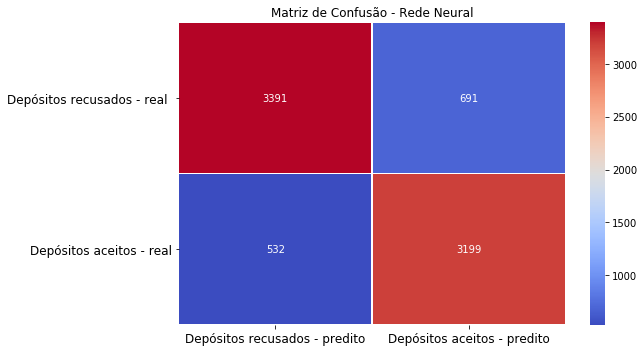

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
# 4697: no's, 4232: yes
conf_matrix = confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax,cmap="coolwarm")
plt.title("Matriz de Confusão - Rede Neural", fontsize=12)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Depósitos recusados - predito', 'Depósitos aceitos - predito'], fontsize=12)
ax.set_yticklabels(['Depósitos recusados - real ', 'Depósitos aceitos - real'], fontsize=12, rotation=360)

plt.show()

In [25]:
# Let's find the scores  for precision and recall.
from sklearn.metrics import precision_score, recall_score
# The model is 77% sure that the potential client will suscribe to a term deposit. 
# The model is only retaining 60% of clients that agree to suscribe a term deposit.
print('Precision Score: ', precision_score(y_train, y_train_pred))
# The classifier only detects 60% of potential clients that will suscribe to a term deposit.
print('Recall Score: ', recall_score(y_train, y_train_pred))

Precision Score:  0.8223650385604113
Recall Score:  0.8574108818011257


In [26]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred)

0.8395223723920746

In [27]:
y_scores = neural_clf.decision_function([some_instance])
y_scores

AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

In [28]:
# Increasing the threshold decreases the recall.
threshold = 0
y_some_digit_pred = (y_scores > threshold)

NameError: name 'y_scores' is not defined

In [29]:
y_scores = cross_val_predict(neural_clf, X_train, y_train, cv=10, method="predict_proba")
#neural_y_scores = cross_val_predict(neural_clf, X_train, y_train, cv=10, method="predict_proba")
#naives_y_scores = cross_val_predict(nav_clf, X_train, y_train, cv=10, method="predict_proba")

In [30]:
# hack to work around issue #9589 introduced in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]



In [31]:
y_scores.shape

(7813,)

In [32]:
# How can we decide which threshold to use? We want to return the scores instead of predictions with this code.
from sklearn.metrics import precision_recall_curve

precisions, recalls, threshold = precision_recall_curve(y_train, y_scores)

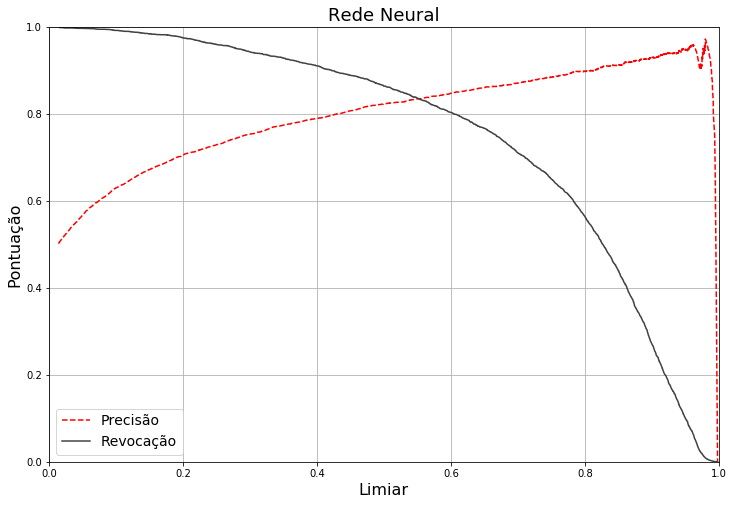

In [34]:
def precision_recall_curve(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "r--", label="Precisão")
    plt.plot(thresholds, recalls[:-1], "#424242", label="Revocação")
    plt.title("Rede Neural", fontsize=18)
    plt.ylabel("Pontuação", fontsize=16)
    plt.xlabel("Limiar", fontsize=16)
    plt.legend(loc="best", fontsize=14)
    plt.xlim([0,1])
    plt.ylim([0, 1])
    plt.grid()
    #plt.axvline(x=0.13, linewidth=3, color="#0B3861")
    #plt.annotate('Best Precision and \n Recall Balance \n is at 0.13 \n threshold ', xy=(0.13, 0.83), xytext=(55, -40),
             #textcoords="offset points",arrowprops=dict(facecolor='black', shrink=0.05),fontsize=12, color='k')
    
precision_recall_curve(precisions, recalls, threshold)
plt.show()

In [35]:
from sklearn.metrics import roc_curve,roc_auc_score
# Gradient Boosting Classifier
# Neural Classifier
# Naives Bayes Classifier
neu_fpr, neu_tpr, thresold = roc_curve(y_train, y_scores)
#neu_fpr, neu_tpr, neu_threshold = roc_curve(y_train, neural_y_scores)
#nav_fpr, nav_tpr, nav_threshold = roc_curve(y_train, naives_y_scores)
roc_auc_score(y_train, y_scores)

0.9162728262523915

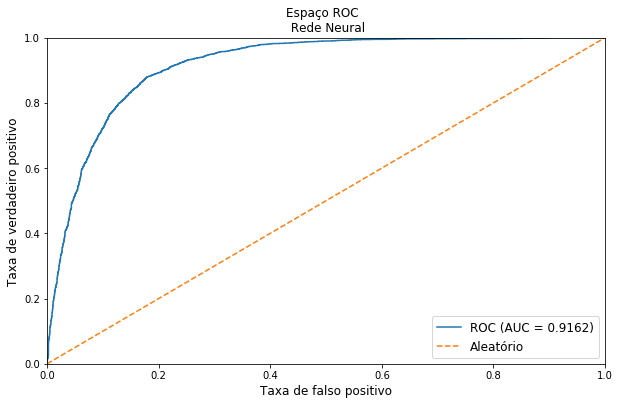

In [36]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.title('Espaço ROC  \n Rede Neural', fontsize=12)
    plt.plot(false_positive_rate, true_positive_rate, label="ROC (AUC = 0.9162)")
    plt.plot([0, 1], [0, 1], '--',label="Aleatório")
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taxa de falso positivo', fontsize=12)
    plt.ylabel('Taxa de verdadeiro positivo', fontsize=12)
    plt.legend(loc='lower right',fontsize=12)
    #plt.annotate('ROC Score of 91.73% \n ', xy=(0.25, 0.9), xytext=(0.4, 0.9),
            #arrowprops=dict(facecolor='#F75118', shrink=0.05),
            #)
    #plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                #arrowprops=dict(facecolor='#F75118', shrink=0.05),
                #)
    
    
graph_roc_curve(neu_fpr, neu_tpr, threshold)
plt.show()

In [80]:
from sklearn.metrics import roc_auc_score

print('Gradient Boost Classifier Score: ', roc_auc_score(y_train, y_scores))
print('Neural Classifier Score: ', roc_auc_score(y_train, neural_y_scores))
print('Naives Bayes Classifier: ', roc_auc_score(y_train, naives_y_scores))

Gradient Boost Classifier Score:  0.9191511756086115
Neural Classifier Score:  0.9155876352721624
Naives Bayes Classifier:  0.8036257608021531


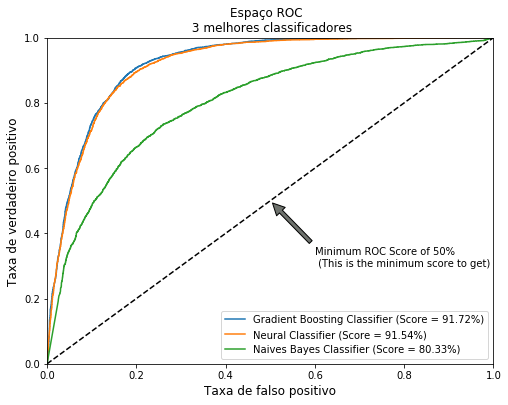

In [83]:
def graph_roc_curve_multiple(grd_fpr, grd_tpr, neu_fpr, neu_tpr, nav_fpr, nav_tpr):
    plt.figure(figsize=(8,6))
    plt.title('Espaço ROC  \n 3 melhores classificadores', fontsize=12)
    plt.plot(grd_fpr, grd_tpr, label='Gradient Boosting Classifier (Score = 91.72%)')
    plt.plot(neu_fpr, neu_tpr, label='Neural Classifier (Score = 91.54%)')
    plt.plot(nav_fpr, nav_tpr, label='Naives Bayes Classifier (Score = 80.33%)')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taxa de falso positivo', fontsize=12)
    plt.ylabel('Taxa de verdadeiro positivo', fontsize=12)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(grd_fpr, grd_tpr, neu_fpr, neu_tpr, nav_fpr, nav_tpr)
plt.show()

In [84]:
grad_clf.predict_proba([some_instance])

array([[0.97482622, 0.02517378]])

In [85]:
# Let's see what does our classifier predict.
grad_clf.predict([some_instance]) 

array([0])

In [86]:
y_train[1250]

0

Feature ranking:
1. feature 11 (0.591310)
2. feature 8 (0.129966)
3. feature 6 (0.067020)
4. feature 13 (0.049923)
5. feature 15 (0.038138)
6. feature 14 (0.037830)
7. feature 10 (0.026646)
8. feature 5 (0.025842)
9. feature 0 (0.017757)
10. feature 12 (0.007889)
11. feature 3 (0.005280)
12. feature 9 (0.002200)
13. feature 2 (0.000147)
14. feature 1 (0.000050)
15. feature 7 (0.000000)
16. feature 4 (0.000000)


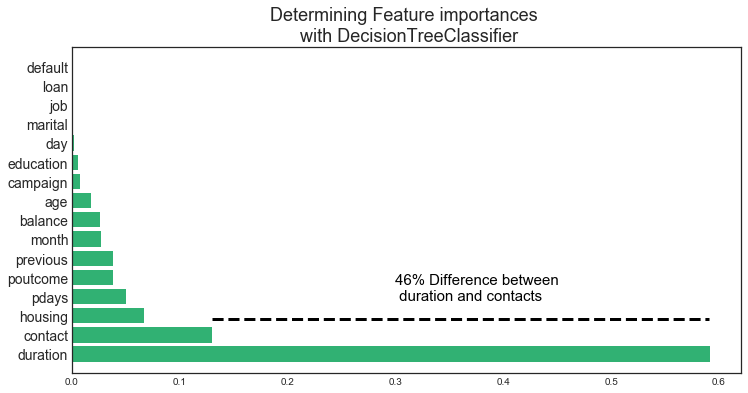

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
plt.style.use('seaborn-white')

# Convert the columns into categorical variables
term_deposits['job'] = term_deposits['job'].astype('category').cat.codes
term_deposits['marital'] = term_deposits['marital'].astype('category').cat.codes
term_deposits['education'] = term_deposits['education'].astype('category').cat.codes
term_deposits['contact'] = term_deposits['contact'].astype('category').cat.codes
term_deposits['poutcome'] = term_deposits['poutcome'].astype('category').cat.codes
term_deposits['month'] = term_deposits['month'].astype('category').cat.codes
term_deposits['default'] = term_deposits['default'].astype('category').cat.codes
term_deposits['loan'] = term_deposits['loan'].astype('category').cat.codes
term_deposits['housing'] = term_deposits['housing'].astype('category').cat.codes

# Let's create new splittings like before but now we modified the data so we need to do it one more time.
# Create train and test splits
target_name = 'deposit'
X = term_deposits.drop('deposit', axis=1)


label=term_deposits[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,label,test_size=0.2, random_state=42, stratify=label)

# Build a classification task using 3 informative features
tree = tree.DecisionTreeClassifier(
    class_weight='balanced',
    min_weight_fraction_leaf = 0.01
    
)



tree = tree.fit(X_train, y_train)
importances = tree.feature_importances_
feature_names = term_deposits.drop('deposit', axis=1).columns
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(12,6))
    plt.title("Determining Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#31B173',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])
    plt.axhline(y=1.85, xmin=0.21, xmax=0.952, color='k', linewidth=3, linestyle='--')
    plt.text(0.30, 2.8, '46% Difference between \n duration and contacts', color='k', fontsize=15)
    
feature_importance_graph(indices, importances, feature_names)
plt.show()

In [88]:
# Our three classifiers are grad_clf, nav_clf and neural_clf
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('gbc', grad_clf), ('nav', nav_clf), ('neural', neural_clf)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='deviance',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                             

In [89]:
from sklearn.metrics import accuracy_score

for clf in (grad_clf, nav_clf, neural_clf, voting_clf):
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, predict))

GradientBoostingClassifier 0.8463949843260188
GaussianNB 0.7514554411106136
MLPClassifier 0.77384684281236
VotingClassifier 0.8060904612628751


In [65]:
# Cross validate Classifier
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(svc_clf, X_train, y_train, cv=10)

In [66]:
from sklearn.metrics import accuracy_score
svc_clf.fit(X_train, y_train)
print ("A acurácia do modelo SVM  %2.2f" % accuracy_score(y_train, y_train_pred))

A acurácia do modelo SVM  0.86


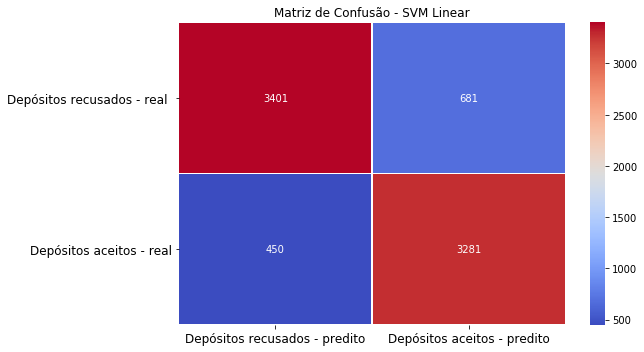

In [67]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
conf_matrix = confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax,cmap="coolwarm")
plt.title("Matriz de Confusão - SVM Linear", fontsize=12)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Depósitos recusados - predito', 'Depósitos aceitos - predito'], fontsize=12)
ax.set_yticklabels(['Depósitos recusados - real ', 'Depósitos aceitos - real'], fontsize=12, rotation=360)

plt.show()

In [68]:
from sklearn.metrics import precision_score, recall_score
print('Precision Score: ', precision_score(y_train, y_train_pred))
print('Recall Score: ', recall_score(y_train, y_train_pred))
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)

Precision Score:  0.8281171125694093
Recall Score:  0.8793889037791477


0.8529832315091641

In [69]:
y_scores = svc_clf.decision_function([some_instance])
y_scores

threshold = 0
y_some_digit_pred = (y_scores > threshold)

y_scores = cross_val_predict(svc_clf, X_train, y_train, cv=10, method="decision_function")


In [70]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]
y_scores.shape

(7813,)

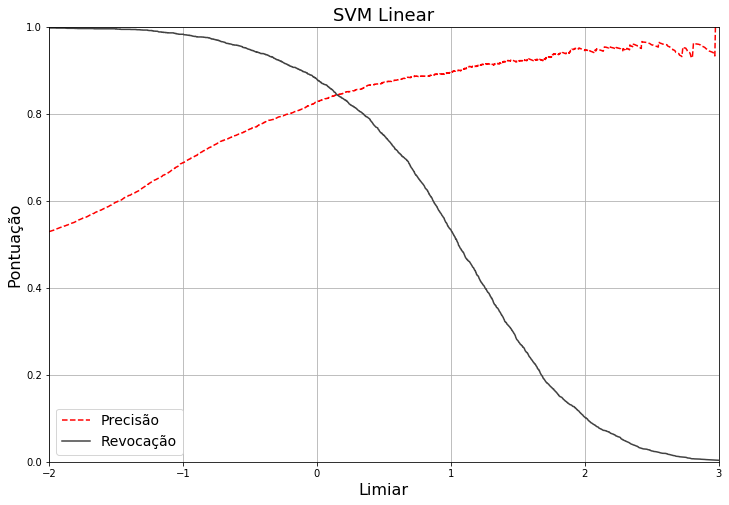

In [73]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, threshold = precision_recall_curve(y_train, y_scores)

def precision_recall_curve(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "r--", label="Precisão")
    plt.plot(thresholds, recalls[:-1], "#424242", label="Revocação")
    plt.title("SVM Linear", fontsize=18)
    plt.ylabel("Pontuação", fontsize=16)
    plt.xlabel("Limiar", fontsize=16)
    plt.legend(loc="best", fontsize=14)
    plt.xlim([-2,3])
    plt.ylim([0, 1])
    plt.grid()
precision_recall_curve(precisions, recalls, threshold)
plt.show()


In [74]:
from sklearn.metrics import roc_curve,roc_auc_score
svc_fpr, svc_tpr, thresold = roc_curve(y_train, y_scores)
roc_auc_score(y_train, y_scores)

0.9195216239168869

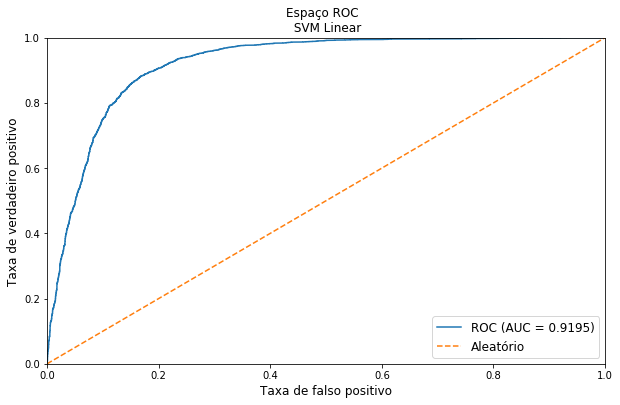

In [76]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.title('Espaço ROC  \n SVM Linear', fontsize=12)
    plt.plot(false_positive_rate, true_positive_rate, label="ROC (AUC = 0.9195)")
    plt.plot([0, 1], [0, 1], '--',label="Aleatório")
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taxa de falso positivo', fontsize=12)
    plt.ylabel('Taxa de verdadeiro positivo', fontsize=12)
    plt.legend(loc='lower right',fontsize=12)   
    
graph_roc_curve(svc_fpr, svc_tpr, threshold)
plt.show()

In [77]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(knn_clf, X_train, y_train, cv=10)


from sklearn.metrics import accuracy_score
knn_clf.fit(X_train, y_train)
print ("A acurácia do modelo KNN  %2.2f" % accuracy_score(y_train, y_train_pred))

A acurácia do modelo KNN  0.80


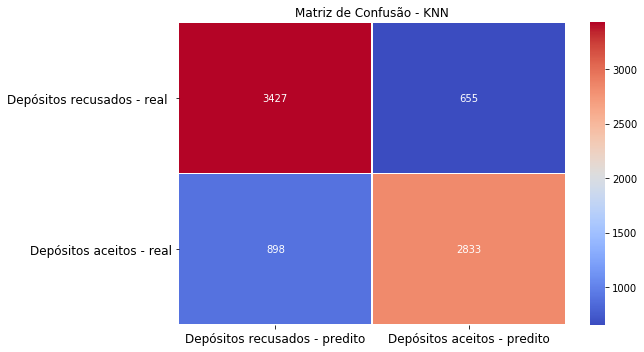

In [78]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
conf_matrix = confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax,cmap="coolwarm")
plt.title("Matriz de Confusão - KNN", fontsize=12)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Depósitos recusados - predito', 'Depósitos aceitos - predito'], fontsize=12)
ax.set_yticklabels(['Depósitos recusados - real ', 'Depósitos aceitos - real'], fontsize=12, rotation=360)
plt.show()

In [80]:
from sklearn.metrics import precision_score, recall_score
print('Precision Score: ', precision_score(y_train, y_train_pred))
print('Recall Score: ', recall_score(y_train, y_train_pred))
from sklearn.metrics import f1_score
f1 = f1_score(y_train, y_train_pred)
print('F1: ',f1) 

Precision Score:  0.8122133027522935
Recall Score:  0.7593138568748324
F1:  0.7848732511428176


In [87]:
y_scores = cross_val_predict(knn_clf, X_train, y_train, cv=10, method="decision_function")


AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

In [89]:
from sklearn.metrics import roc_curve,roc_auc_score
knn_fpr, knn_tpr, thresold = roc_curve(y_train, y_scores)
roc_auc_score(y_train, y_scores)


0.9195216239168869

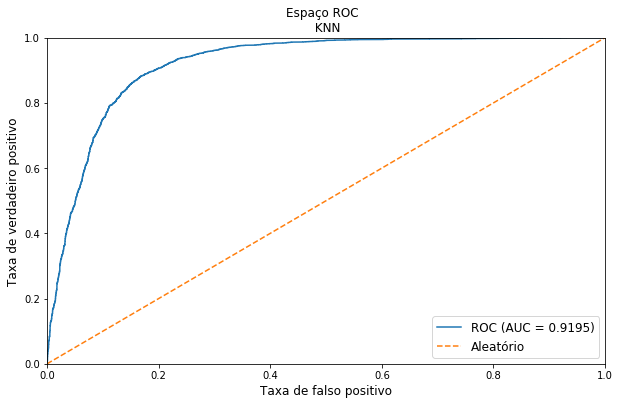

In [90]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.title('Espaço ROC  \n KNN', fontsize=12)
    plt.plot(false_positive_rate, true_positive_rate, label="ROC (AUC = 0.9195)")
    plt.plot([0, 1], [0, 1], '--',label="Aleatório")
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taxa de falso positivo', fontsize=12)
    plt.ylabel('Taxa de verdadeiro positivo', fontsize=12)
    plt.legend(loc='lower right',fontsize=12)   
    
graph_roc_curve(knn_fpr, knn_tpr, threshold)
plt.show()

In [91]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(grad_clf, X_train, y_train, cv=10)


from sklearn.metrics import accuracy_score
grad_clf.fit(X_train, y_train)
print ("A acurácia do modelo Gradient Boosting  %2.2f" % accuracy_score(y_train, y_train_pred))

A acurácia do modelo Gradient Boosting  0.85


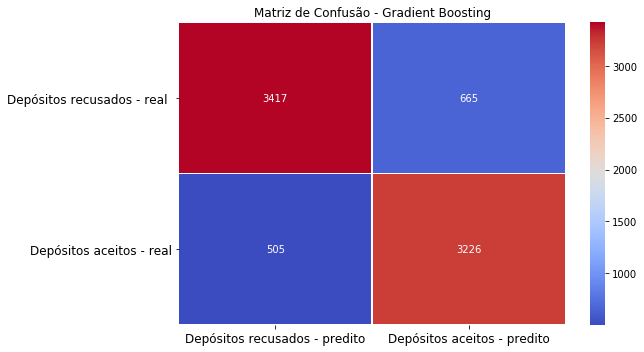

In [92]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
conf_matrix = confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax,cmap="coolwarm")
plt.title("Matriz de Confusão - Gradient Boosting", fontsize=12)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Depósitos recusados - predito', 'Depósitos aceitos - predito'], fontsize=12)
ax.set_yticklabels(['Depósitos recusados - real ', 'Depósitos aceitos - real'], fontsize=12, rotation=360)
plt.show()

In [93]:
from sklearn.metrics import precision_score, recall_score
print('Precision Score: ', precision_score(y_train, y_train_pred))
print('Recall Score: ', recall_score(y_train, y_train_pred))
from sklearn.metrics import f1_score
f1 = f1_score(y_train, y_train_pred)
print('F1: ',f1) 

Precision Score:  0.8290927782061167
Recall Score:  0.8646475475743769
F1:  0.8464969824193125


In [94]:
y_scores = grad_clf.decision_function([some_instance])
y_scores

threshold = 0
y_some_digit_pred = (y_scores > threshold)

y_scores = cross_val_predict(grad_clf, X_train, y_train, cv=10, method="decision_function")


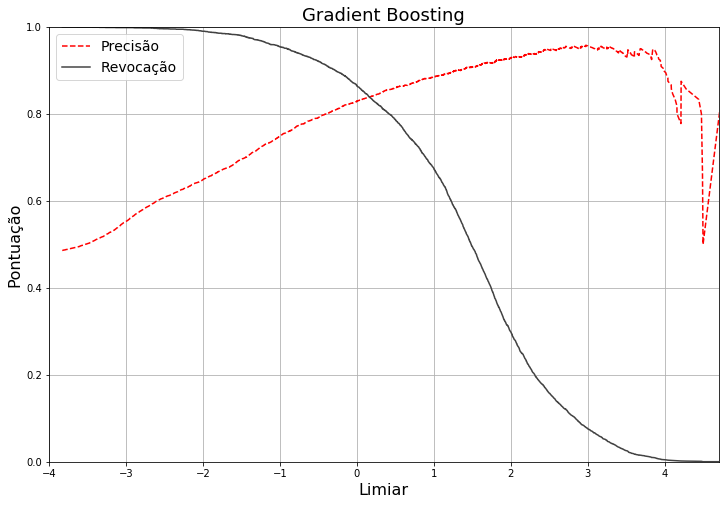

In [95]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]
y_scores.shape

from sklearn.metrics import precision_recall_curve
precisions, recalls, threshold = precision_recall_curve(y_train, y_scores)

def precision_recall_curve(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "r--", label="Precisão")
    plt.plot(thresholds, recalls[:-1], "#424242", label="Revocação")
    plt.title("Gradient Boosting", fontsize=18)
    plt.ylabel("Pontuação", fontsize=16)
    plt.xlabel("Limiar", fontsize=16)
    plt.legend(loc="best", fontsize=14)
    plt.xlim([-4, 4.7])
    plt.ylim([0, 1])
    plt.grid()
precision_recall_curve(precisions, recalls, threshold)
plt.show()

In [96]:
from sklearn.metrics import roc_curve,roc_auc_score
grad_fpr, grad_tpr, thresold = roc_curve(y_train, y_scores)
roc_auc_score(y_train, y_scores)

0.9200102666182184

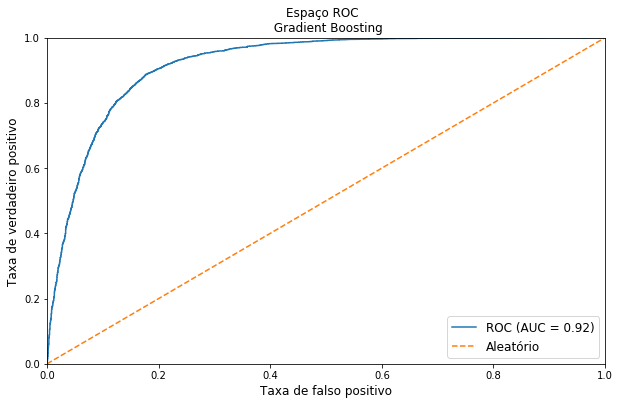

In [98]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.title('Espaço ROC  \n grad', fontsize=12)
    plt.plot(false_positive_rate, true_positive_rate, label="ROC (AUC = 0.92)")
    plt.plot([0, 1], [0, 1], '--',label="Aleatório")
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taxa de falso positivo', fontsize=12)
    plt.ylabel('Taxa de verdadeiro positivo', fontsize=12)
    plt.legend(loc='lower right',fontsize=12)   
    
graph_roc_curve(grad_fpr, grad_tpr, threshold)
plt.show()

In [157]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(tree_clf, X_train, y_train, cv=10)

In [158]:
from sklearn.metrics import accuracy_score
tree_clf.fit(X_train, y_train)
print ("A acurácia do modelo Árvore de decisão  %2.4f" % accuracy_score(y_train, y_train_pred))

A acurácia do modelo Árvore de decisão  0.7891


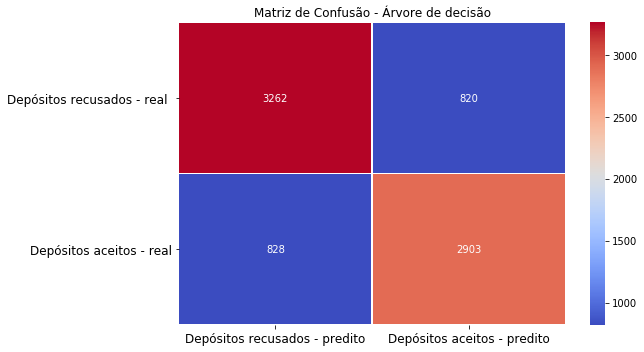

In [159]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
conf_matrix = confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax,cmap="coolwarm")
plt.title("Matriz de Confusão - Árvore de decisão", fontsize=12)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Depósitos recusados - predito', 'Depósitos aceitos - predito'], fontsize=12)
ax.set_yticklabels(['Depósitos recusados - real ', 'Depósitos aceitos - real'], fontsize=12, rotation=360)
plt.show()

In [160]:
from sklearn.metrics import precision_score, recall_score
print('Precision Score: ', precision_score(y_train, y_train_pred))
print('Recall Score: ', recall_score(y_train, y_train_pred))
from sklearn.metrics import f1_score
f1 = f1_score(y_train, y_train_pred)
print('F1: ',f1) 

Precision Score:  0.779747515444534
Recall Score:  0.7780755829536318
F1:  0.7789106519989267


In [161]:
y_scores = cross_val_predict(tree_clf, X_train, y_train, cv=10, method="predict_proba")


if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]
y_scores.shape

(7813,)

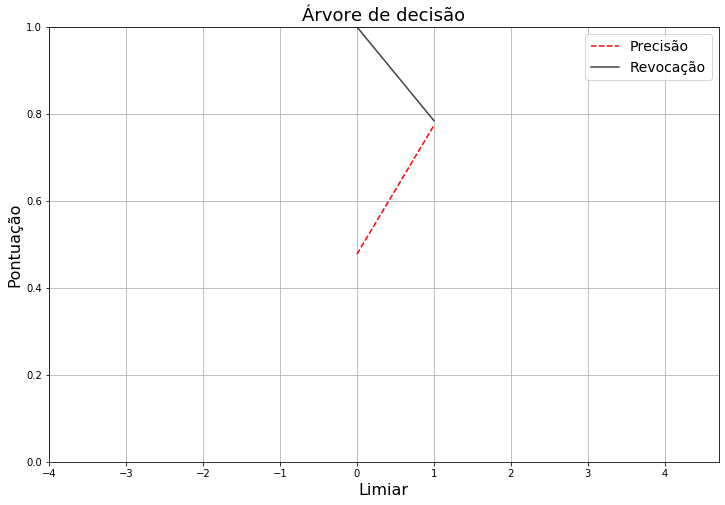

In [162]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]
y_scores.shape

from sklearn.metrics import precision_recall_curve
precisions, recalls, threshold = precision_recall_curve(y_train, y_scores)

def precision_recall_curve(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "r--", label="Precisão")
    plt.plot(thresholds, recalls[:-1], "#424242", label="Revocação")
    plt.title("Árvore de decisão", fontsize=18)
    plt.ylabel("Pontuação", fontsize=16)
    plt.xlabel("Limiar", fontsize=16)
    plt.legend(loc="best", fontsize=14)
    plt.xlim([-4, 4.7])
    plt.ylim([0, 1])
    plt.grid()
precision_recall_curve(precisions, recalls, threshold)
plt.show()

In [163]:
from sklearn.metrics import roc_curve,roc_auc_score
tree_fpr, tree_tpr, thresold = roc_curve(y_train, y_scores)
roc_auc_score(y_train, y_scores)

0.7871585459747648

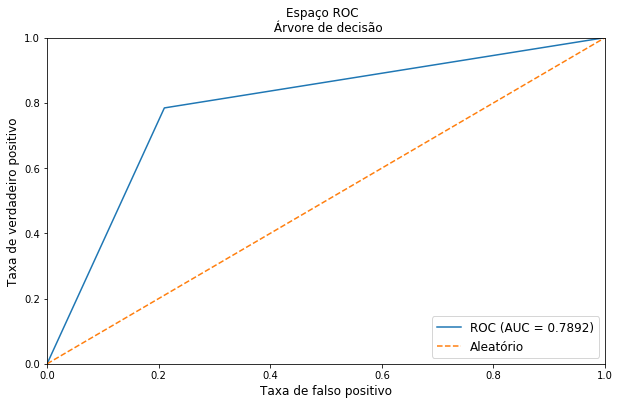

In [164]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.title('Espaço ROC  \n Árvore de decisão', fontsize=12)
    plt.plot(false_positive_rate, true_positive_rate, label="ROC (AUC = 0.7892)")
    plt.plot([0, 1], [0, 1], '--',label="Aleatório")
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taxa de falso positivo', fontsize=12)
    plt.ylabel('Taxa de verdadeiro positivo', fontsize=12)
    plt.legend(loc='lower right',fontsize=12)   
    
graph_roc_curve(tree_fpr, tree_tpr, threshold)
plt.show()

In [136]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(rand_clf, X_train, y_train, cv=10)


In [137]:
from sklearn.metrics import accuracy_score
rand_clf.fit(X_train, y_train)
print ("A acurácia do modelo Floresta aleatória  %2.4f" % accuracy_score(y_train, y_train_pred))

A acurácia do modelo Floresta aleatória  0.8433


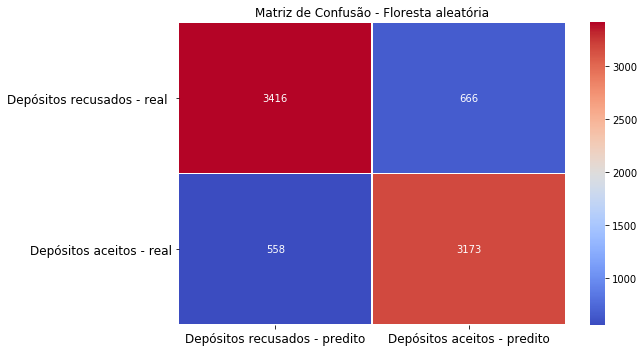

In [138]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
conf_matrix = confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax,cmap="coolwarm")
plt.title("Matriz de Confusão - Floresta aleatória", fontsize=12)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Depósitos recusados - predito', 'Depósitos aceitos - predito'], fontsize=12)
ax.set_yticklabels(['Depósitos recusados - real ', 'Depósitos aceitos - real'], fontsize=12, rotation=360)
plt.show()

In [139]:

from sklearn.metrics import precision_score, recall_score
print('Precision Score: ', precision_score(y_train, y_train_pred))
print('Recall Score: ', recall_score(y_train, y_train_pred))
from sklearn.metrics import f1_score
f1 = f1_score(y_train, y_train_pred)
print('F1: ',f1) 


Precision Score:  0.8265173222193279
Recall Score:  0.8504422406861432
F1:  0.8383091149273447


In [140]:
y_scores = cross_val_predict(rand_clf, X_train, y_train, cv=10, method="predict_proba")


if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]
y_scores.shape

(7813,)

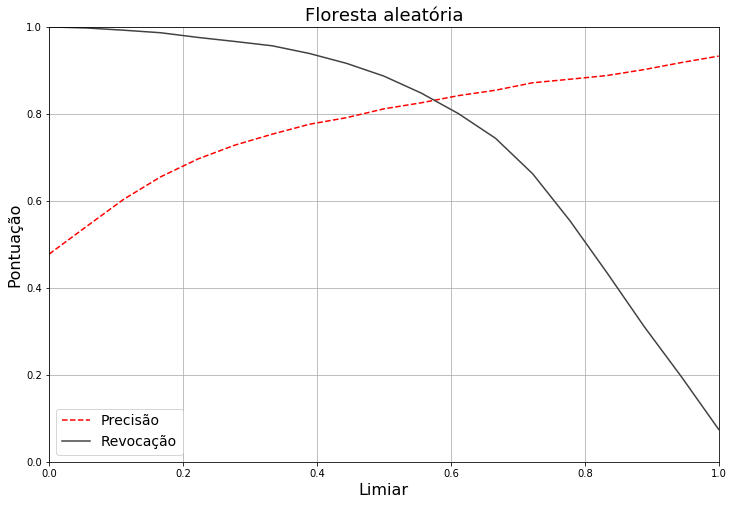

In [142]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]
y_scores.shape

from sklearn.metrics import precision_recall_curve
precisions, recalls, threshold = precision_recall_curve(y_train, y_scores)

def precision_recall_curve(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "r--", label="Precisão")
    plt.plot(thresholds, recalls[:-1], "#424242", label="Revocação")
    plt.title("Floresta aleatória", fontsize=18)
    plt.ylabel("Pontuação", fontsize=16)
    plt.xlabel("Limiar", fontsize=16)
    plt.legend(loc="best", fontsize=14)
    plt.xlim([0,1])
    plt.ylim([0, 1])
    plt.grid()
precision_recall_curve(precisions, recalls, threshold)
plt.show()

In [143]:
from sklearn.metrics import roc_curve,roc_auc_score
rand_fpr, rand_tpr, thresold = roc_curve(y_train, y_scores)
roc_auc_score(y_train, y_scores)



0.9097676800082364

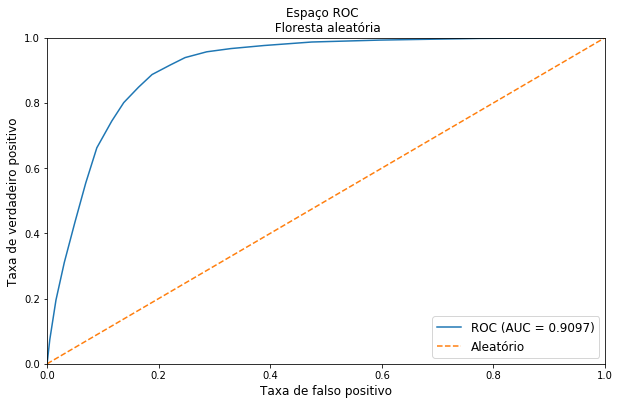

In [145]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.title('Espaço ROC  \n Floresta aleatória', fontsize=12)
    plt.plot(false_positive_rate, true_positive_rate, label="ROC (AUC = 0.9097)")
    plt.plot([0, 1], [0, 1], '--',label="Aleatório")
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taxa de falso positivo', fontsize=12)
    plt.ylabel('Taxa de verdadeiro positivo', fontsize=12)
    plt.legend(loc='lower right',fontsize=12)   
    
graph_roc_curve(rand_fpr, rand_tpr, threshold)
plt.show()

In [124]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(neural_clf, X_train, y_train, cv=10)


from sklearn.metrics import accuracy_score
neural_clf.fit(X_train, y_train)
print ("A acurácia do modelo redes neurais  %2.4f" % accuracy_score(y_train, y_train_pred))


A acurácia do modelo redes neurais  0.8449


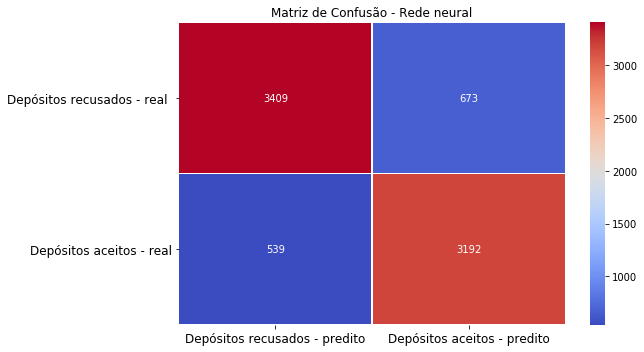

In [126]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
conf_matrix = confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax,cmap="coolwarm")
plt.title("Matriz de Confusão - Rede neural", fontsize=12)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Depósitos recusados - predito', 'Depósitos aceitos - predito'], fontsize=12)
ax.set_yticklabels(['Depósitos recusados - real ', 'Depósitos aceitos - real'], fontsize=12, rotation=360)
plt.show()

In [127]:
from sklearn.metrics import precision_score, recall_score
print('Precision Score: ', precision_score(y_train, y_train_pred))
print('Recall Score: ', recall_score(y_train, y_train_pred))
from sklearn.metrics import f1_score
f1 = f1_score(y_train, y_train_pred)
print('F1: ',f1) 

Precision Score:  0.8258732212160413
Recall Score:  0.8555347091932458
F1:  0.8404423380726698


In [130]:


y_scores = cross_val_predict(neural_clf, X_train, y_train, cv=10, method="predict_proba")


if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]
y_scores.shape


(7813,)

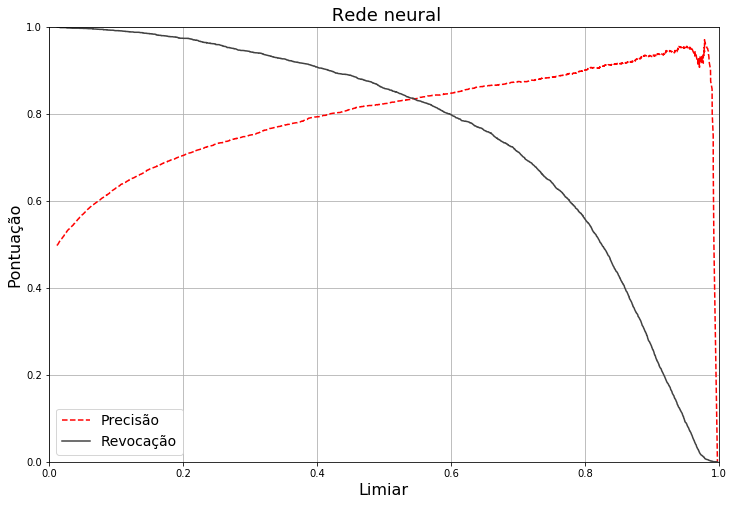

In [133]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, threshold = precision_recall_curve(y_train, y_scores)

def precision_recall_curve(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "r--", label="Precisão")
    plt.plot(thresholds, recalls[:-1], "#424242", label="Revocação")
    plt.title(" Rede neural", fontsize=18)
    plt.ylabel("Pontuação", fontsize=16)
    plt.xlabel("Limiar", fontsize=16)
    plt.legend(loc="best", fontsize=14)
    plt.xlim([0,1])
    plt.ylim([0, 1])
    plt.grid()
precision_recall_curve(precisions, recalls, threshold)
plt.show()


In [134]:
from sklearn.metrics import roc_curve,roc_auc_score
neural_fpr, neural_tpr, thresold = roc_curve(y_train, y_scores)
roc_auc_score(y_train, y_scores)

0.9165414418518469

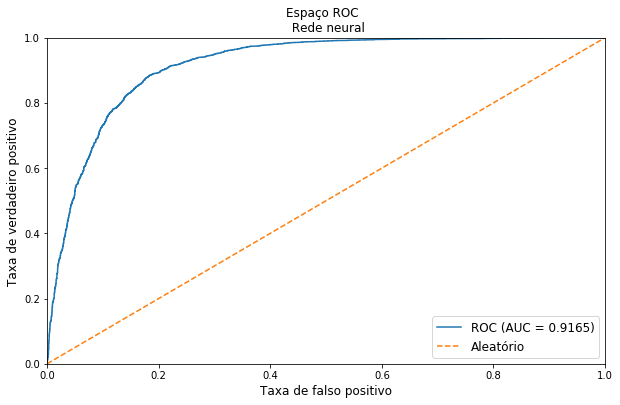

In [135]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.title('Espaço ROC  \n Rede neural', fontsize=12)
    plt.plot(false_positive_rate, true_positive_rate, label="ROC (AUC = 0.9165)")
    plt.plot([0, 1], [0, 1], '--',label="Aleatório")
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taxa de falso positivo', fontsize=12)
    plt.ylabel('Taxa de verdadeiro positivo', fontsize=12)
    plt.legend(loc='lower right',fontsize=12)   
    
graph_roc_curve(neural_fpr, neural_tpr, threshold)
plt.show()

In [165]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(nav_clf, X_train, y_train, cv=10)

In [166]:
from sklearn.metrics import accuracy_score
nav_clf.fit(X_train, y_train)
print ("A acurácia do modelo Naive Bayes  %2.4f" % accuracy_score(y_train, y_train_pred))


A acurácia do modelo Naive Bayes  0.7211


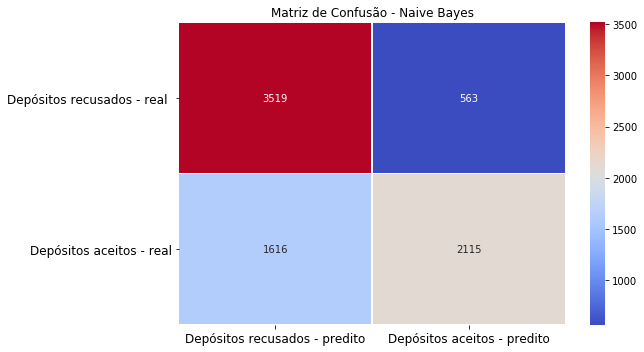

In [167]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
conf_matrix = confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax,cmap="coolwarm")
plt.title("Matriz de Confusão - Naive Bayes", fontsize=12)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Depósitos recusados - predito', 'Depósitos aceitos - predito'], fontsize=12)
ax.set_yticklabels(['Depósitos recusados - real ', 'Depósitos aceitos - real'], fontsize=12, rotation=360)
plt.show()


In [168]:

from sklearn.metrics import precision_score, recall_score
print('Precision Score: ', precision_score(y_train, y_train_pred))
print('Recall Score: ', recall_score(y_train, y_train_pred))
from sklearn.metrics import f1_score
f1 = f1_score(y_train, y_train_pred)
print('F1: ',f1) 

Precision Score:  0.7897684839432412
Recall Score:  0.5668721522380059
F1:  0.6600093618349197


In [170]:

y_scores = cross_val_predict(nav_clf, X_train, y_train, cv=10, method="predict_proba")


if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]
y_scores.shape

(7813,)

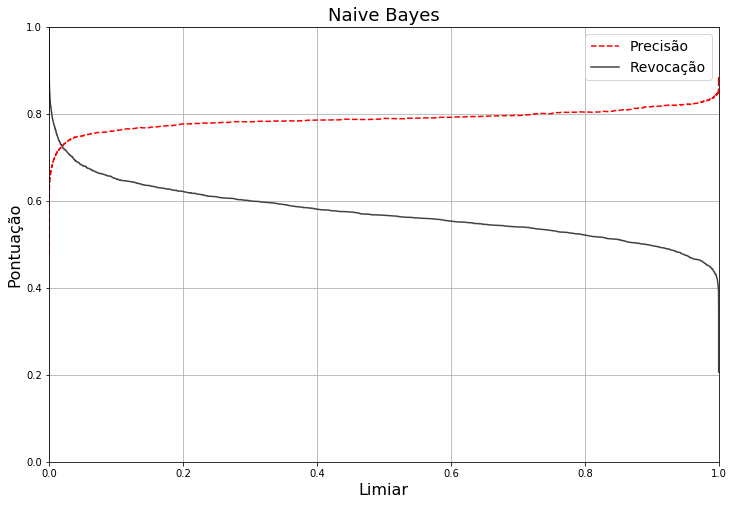

In [175]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, threshold = precision_recall_curve(y_train, y_scores)

def precision_recall_curve(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "r--", label="Precisão")
    plt.plot(thresholds, recalls[:-1], "#424242", label="Revocação")
    plt.title("Naive Bayes", fontsize=18)
    plt.ylabel("Pontuação", fontsize=16)
    plt.xlabel("Limiar", fontsize=16)
    plt.legend(loc="best", fontsize=14)
    plt.xlim([0,1])
    plt.ylim([0, 1])
    plt.grid()
precision_recall_curve(precisions, recalls, threshold)
plt.show()

In [173]:
from sklearn.metrics import roc_curve,roc_auc_score
nav_fpr, nav_tpr, thresold = roc_curve(y_train, y_scores)
roc_auc_score(y_train, y_scores)

0.8065954551895208

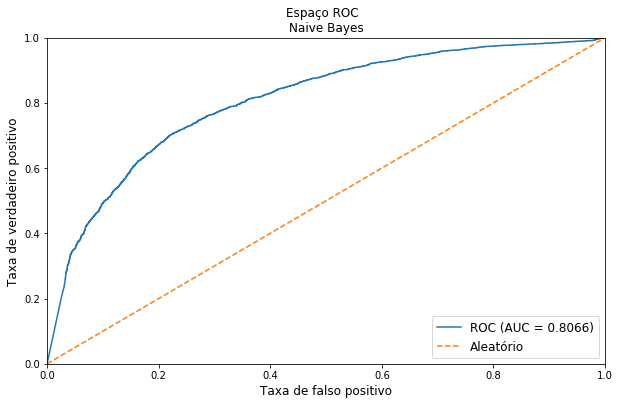

In [177]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.title('Espaço ROC  \nNaive Bayes', fontsize=12)
    plt.plot(false_positive_rate, true_positive_rate, label="ROC (AUC = 0.8066)")
    plt.plot([0, 1], [0, 1], '--',label="Aleatório")
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taxa de falso positivo', fontsize=12)
    plt.ylabel('Taxa de verdadeiro positivo', fontsize=12)
    plt.legend(loc='lower right',fontsize=12)   
    
graph_roc_curve(nav_fpr, nav_tpr, threshold)
plt.show()

Feature ranking:
1. feature 11 (0.591310)
2. feature 8 (0.129966)
3. feature 6 (0.067020)
4. feature 13 (0.049923)
5. feature 15 (0.038138)
6. feature 14 (0.037830)
7. feature 10 (0.026646)
8. feature 5 (0.025842)
9. feature 0 (0.017757)
10. feature 12 (0.007889)
11. feature 3 (0.005280)
12. feature 9 (0.002200)
13. feature 2 (0.000147)
14. feature 1 (0.000050)
15. feature 7 (0.000000)
16. feature 4 (0.000000)


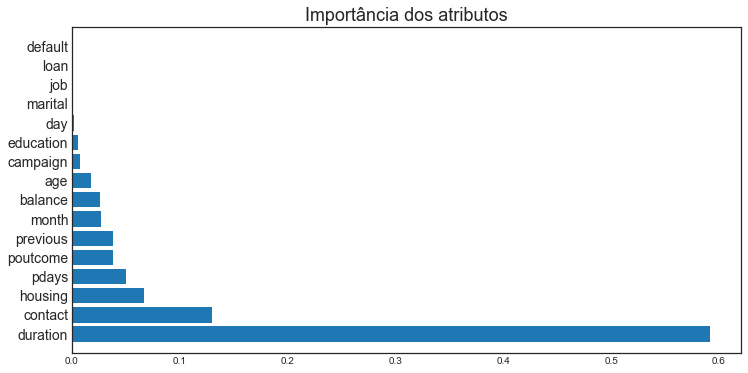

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
plt.style.use('seaborn-white')

# Convert the columns into categorical variables
term_deposits['job'] = term_deposits['job'].astype('category').cat.codes
term_deposits['marital'] = term_deposits['marital'].astype('category').cat.codes
term_deposits['education'] = term_deposits['education'].astype('category').cat.codes
term_deposits['contact'] = term_deposits['contact'].astype('category').cat.codes
term_deposits['poutcome'] = term_deposits['poutcome'].astype('category').cat.codes
term_deposits['month'] = term_deposits['month'].astype('category').cat.codes
term_deposits['default'] = term_deposits['default'].astype('category').cat.codes
term_deposits['loan'] = term_deposits['loan'].astype('category').cat.codes
term_deposits['housing'] = term_deposits['housing'].astype('category').cat.codes

# Let's create new splittings like before but now we modified the data so we need to do it one more time.
# Create train and test splits
target_name = 'deposit'
X = term_deposits.drop('deposit', axis=1)


label=term_deposits[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,label,test_size=0.2, random_state=42, stratify=label)

# Build a classification task using 3 informative features
tree = tree.DecisionTreeClassifier(
    class_weight='balanced',
    min_weight_fraction_leaf = 0.01
    
)



tree = tree.fit(X_train, y_train)
importances = tree.feature_importances_
feature_names = term_deposits.drop('deposit', axis=1).columns
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(12,6))
    plt.title("Importância dos atributos", fontsize=18)
    plt.barh(range(len(indices)), importances[indices],  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])
    #plt.axhline(y=1.85, xmin=0.21, xmax=0.952, color='k', linewidth=3, linestyle='--')
    #plt.text(0.30, 2.8, '46% Difference between \n duration and contacts', color='k', fontsize=15)
    
feature_importance_graph(indices, importances, feature_names)
plt.show()

|--- feature_11 <= 206.50
|   |--- feature_13 <= 9.50
|   |   |--- feature_10 <= 9.50
|   |   |   |--- feature_10 <= 0.50
|   |   |   |   |--- class: no
|   |   |   |--- feature_10 >  0.50
|   |   |   |   |--- class: no
|   |   |--- feature_10 >  9.50
|   |   |   |--- feature_11 <= 77.50
|   |   |   |   |--- class: no
|   |   |   |--- feature_11 >  77.50
|   |   |   |   |--- class: yes
|   |--- feature_13 >  9.50
|   |   |--- feature_15 <= 1.50
|   |   |   |--- feature_11 <= 139.50
|   |   |   |   |--- class: no
|   |   |   |--- feature_11 >  139.50
|   |   |   |   |--- class: no
|   |   |--- feature_15 >  1.50
|   |   |   |--- feature_11 <= 119.50
|   |   |   |   |--- class: no
|   |   |   |--- feature_11 >  119.50
|   |   |   |   |--- class: yes
|--- feature_11 >  206.50
|   |--- feature_11 <= 441.50
|   |   |--- feature_8 <= 1.50
|   |   |   |--- feature_13 <= 0.00
|   |   |   |   |--- class: yes
|   |   |   |--- feature_13 >  0.00
|   |   |   |   |--- class: yes
|   |   |--- featur

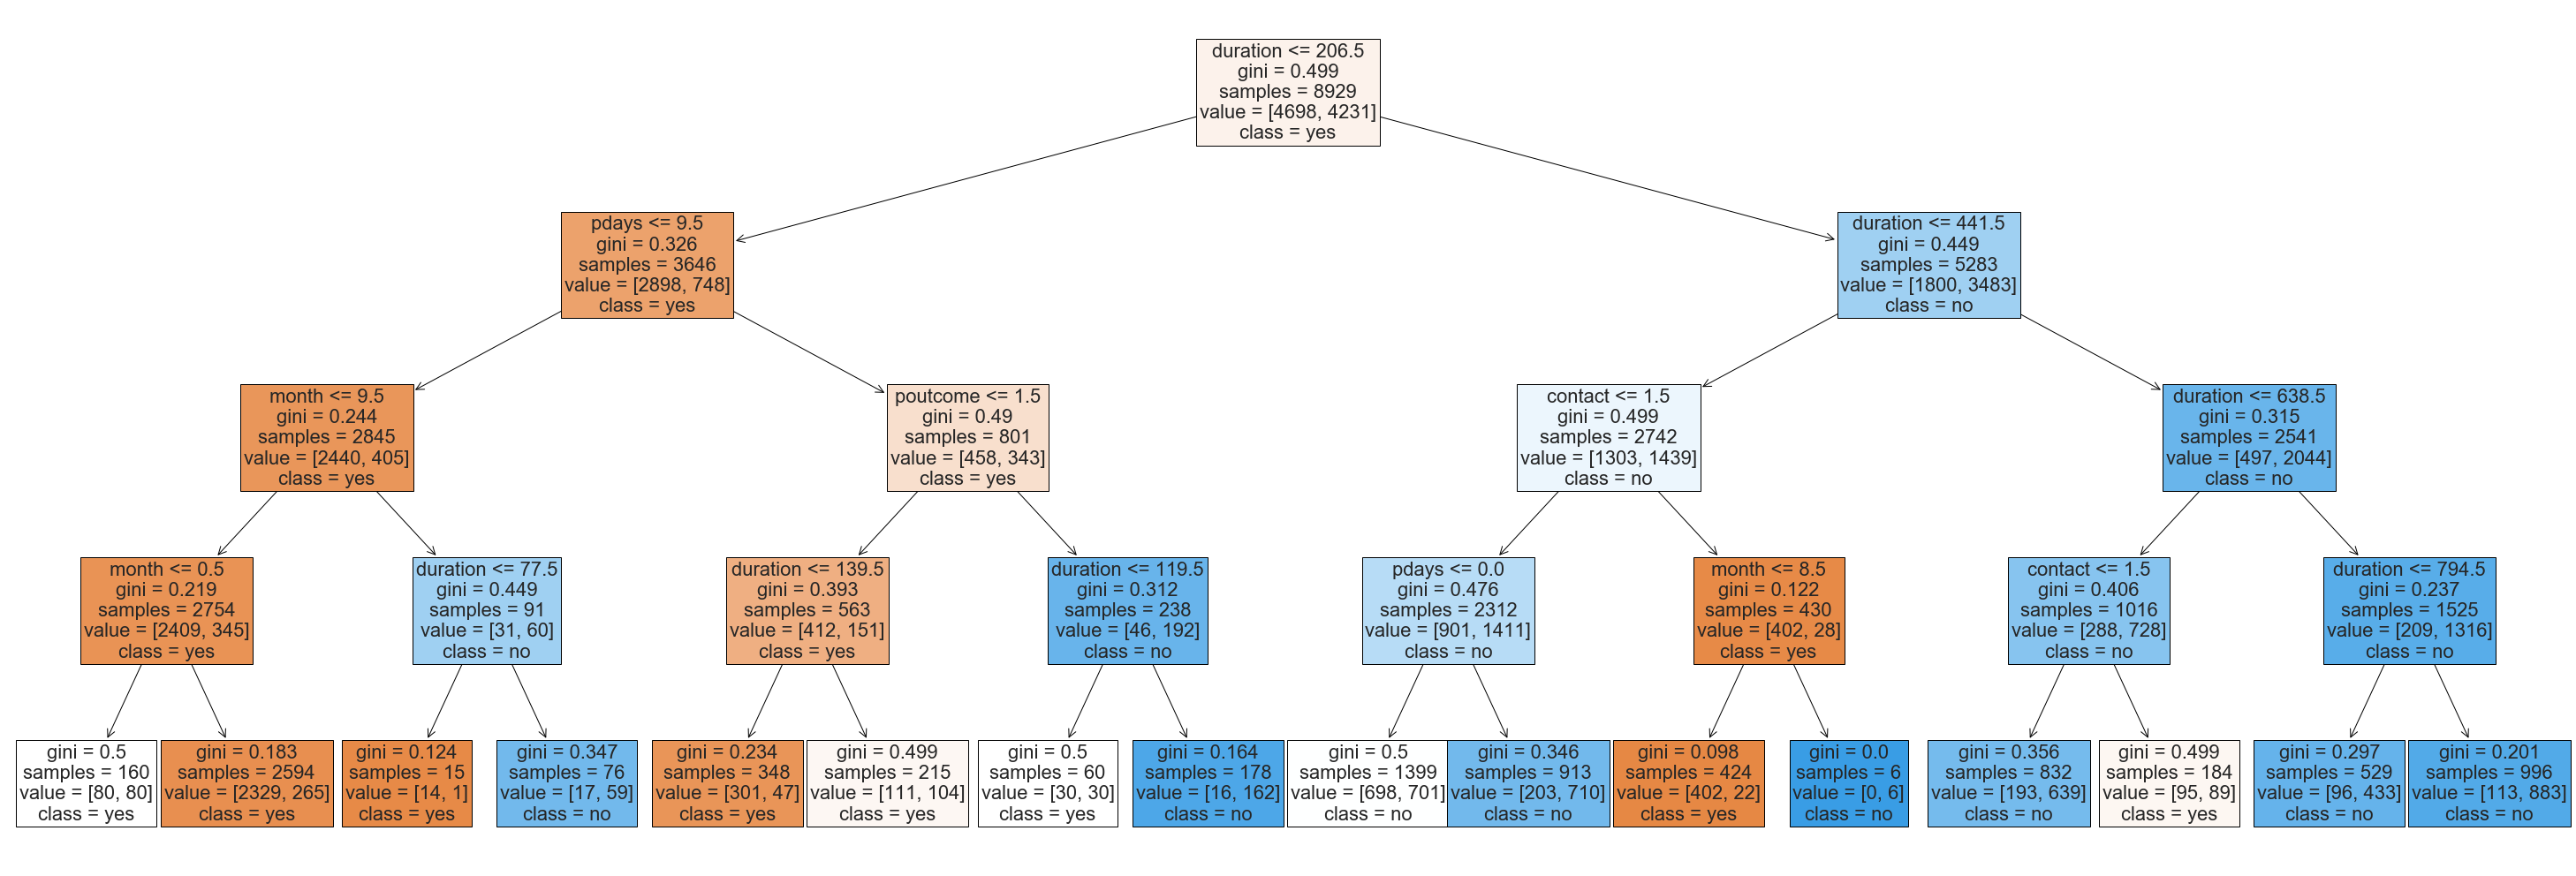

In [193]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(tree_clf, X_train, y_train, cv=10)
cn=['yes', 'no']
from sklearn.metrics import accuracy_score

DTR = tree_clf.fit(X_train, y_train)
pred_dtr = DTR.predict(X_test)



DTR = DecisionTreeClassifier(max_depth=4)
model = DTR.fit(X_train, y_train)

text_representation = tree.export_text(DTR)
print(text_representation)


fig = plt.figure(figsize=(52, 18))
_ = tree.plot_tree(DTR,  feature_names=df.columns, class_names=cn, filled=True, fontsize=22)


In [18]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(tree_clf, X_train, y_train, cv=10)



In [19]:
from sklearn.metrics import accuracy_score
tree_clf.fit(X_train, y_train)
print ("A acurácia do modelo Árvore de decisão  %2.4f" % accuracy_score(y_train, y_train_pred))


A acurácia do modelo Árvore de decisão  0.7863


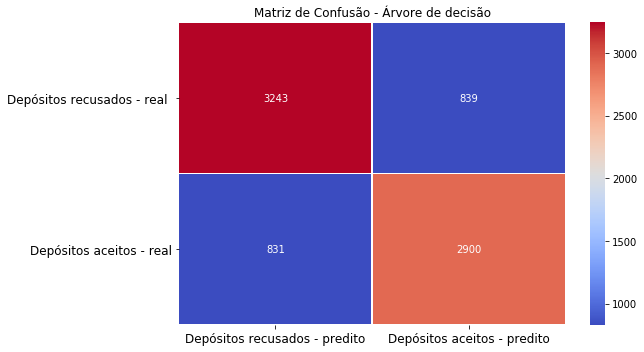

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
conf_matrix = confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax,cmap="coolwarm")
plt.title("Matriz de Confusão - Árvore de decisão", fontsize=12)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Depósitos recusados - predito', 'Depósitos aceitos - predito'], fontsize=12)
ax.set_yticklabels(['Depósitos recusados - real ', 'Depósitos aceitos - real'], fontsize=12, rotation=360)
plt.show()

In [21]:
from sklearn.metrics import precision_score, recall_score
print('Precision Score: ', precision_score(y_train, y_train_pred))
print('Recall Score: ', recall_score(y_train, y_train_pred))
from sklearn.metrics import f1_score
f1 = f1_score(y_train, y_train_pred)
print('F1: ',f1) 

Precision Score:  0.775608451457609
Recall Score:  0.777271508978826
F1:  0.7764390896921016


In [22]:
y_scores = cross_val_predict(tree_clf, X_train, y_train, cv=10, method="predict_proba")


if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]
y_scores.shape

(7813,)

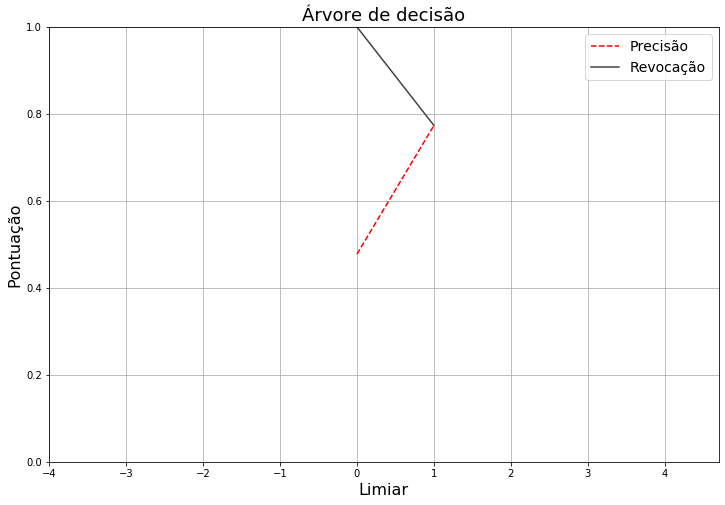

In [24]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, threshold = precision_recall_curve(y_train, y_scores)

def precision_recall_curve(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "r--", label="Precisão")
    plt.plot(thresholds, recalls[:-1], "#424242", label="Revocação")
    plt.title("Árvore de decisão", fontsize=18)
    plt.ylabel("Pontuação", fontsize=16)
    plt.xlabel("Limiar", fontsize=16)
    plt.legend(loc="best", fontsize=14)
    plt.xlim([-4, 4.7])
    plt.ylim([0, 1])
    plt.grid()
precision_recall_curve(precisions, recalls, threshold)
plt.show()
